## El problema
Hoy es tu primer día de trabajo como científico de datos en TodoVentas S.A⚡️, una
empresa familiar especializada en el comercio retail online. Después de realizar un análisis
exhaustivo del mercado utilizando reglas comerciales, se están planteando llevar a cabo
una ampliación de capital. Para ello, quieren saber cuál es el valor que puede tener su
empresa en el futuro expresado por sus beneficios esperados y quieren que les ayudes a
abordar esta cuestión. El objetivo consiste en **predecir cuál será su beneficio diario durante
los próximos meses.**


La empresa te distribuye una muestra representativa de las ventas del último año. Se han
fijado un **horizonte de predicción de tres meses** teniendo en cuenta la última fecha de
transacciones disponible (el 9 de Diciembre de 2023). Debes construir una métrica
adecuada para llevar a cabo la tarea utilizando los datos que se ofrecen así como
seleccionar y justificar el modelo predictivo que mejor se ajuste al objetivo.

Tu tarea consiste en elaborar un informe en formato notebook (ipynb) que muestre los
aspectos más relevantes relacionados con la evolución de los beneficios de TodoVentas
S.A⚡️durante el último ejercicio y las predicciones de beneficios para el próximo trimestre.



## Evaluación
El trabajo se evaluará en un máximo de 10 puntos distribuidos de la siguiente manera:
- 5 puntos - Desarrollo, ejecución y resultados de los algoritmos.
- 3 puntos - Carga de datos y análisis descriptivo
- 1.5 puntos - Escritura y narrativa (story telling) - ten en cuenta que tu informe no está únicamente destinado al área técnica si no que puede circularse también a una audiencia poco familiarizada con los datos (por ejemplo accionistas principales)
- 0.5 puntos - Limpieza y eficiencia del código.


**Estructura del informe**
El informe debería tener una estructura con los siguientes apartados
1. Introducción y Preprocesamiento: Análisis descriptivo
- Énfasis en variables temporales y estacionalidad.
- Análisis de autocorrelación y autocorrelación parcial.
- Descomposición de los componentes de la serie temporal

Es importante apoyar tus ideas con visualizaciones

2. Desarrollo de Métodos
- SARIMAX
- Prophet
- Boosting
- Otros ….

3. Análisis de Resultados y Selección de Modelo
- Comparación de modelos.
- Selección de modelo basada en criterios y métricas.


**Entrega**
Fecha límite: 04 Febrero 23:59 (CET)
Formato: Jupyter Notebook. La definición del notebook debe ser:
1023_SeriesTemporales_<Nombre_Apellido>
Email: eduardogonzaloalmorox@gmail.com

In [129]:
# importamos todas las bibliotecas necesarias para el ejercicio.

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white
# SSL to overcome problem with ssl whn applying pd.read_csv()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random

from datetime import datetime, timezone, time, timedelta, date

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric

# Prophet evaluation
from prophet.diagnostics import cross_validation, performance_metrics


rcParams['figure.figsize'] = 15, 8
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

### ROADMAP

1. Analisis preliminar inicial (head, info)

2. Preprocesamiento 
- Tratamiento de datos y tipos
- Fechas
- Nulos
- Duplicados
- Creacion de nuevas variables si necesario.

3. Preparacion modelo series temporales
- Creacion df(index tiempo y variable a predecir)
- Descomposicion Temporal (Tendencia, Estacionalidad, Ruido)
- Evaluacion estacionaridad (Dickey-Fuller) y tendencia (Mann-Kendall). Diferenciacion/detrending si fuera necesario
- Autocorrelacion

4. ARIMA (AutoARIMA)
- Busqueda mejores parametros
- Ajuste del modelo
- Prediccion y visualizacion de la prediccion.
- Visualizacion de diagnisticos
- Obtención primera metrica (baseline)

5. Second Iteration: Prophet, XGBoost others...
- Comparacion distintos modelos.
- Validacion cruzada/split validation.


In [130]:
df=pd.read_csv('online_retail_sales.csv')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


![Aqui he incluido una captura de pantalla de la diapositiva con el esquema de las etapas de la checklist de ML, está en local asi que no lo podrás ver. Lo he hecho para organización personal](tabla_columnas.PNG)

In [131]:
import skimpy as sk
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541909 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA       ┃ NA %   ┃ mean   ┃ sd    ┃ p0       ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Quantity      │        0 │      0 │    9.6 │   220 │   -81000 │      1 │      3 │     10 │  81000 │     ▇  │  │
│ │ UnitPrice     │        0 │      0 │    4.6 │    97 │   -11000 │    1.2 │    2.1 │    4.1 │  39000 │    ▇   │  │
│ │ CustomerID    │   135080 │  24.93 │  15000 │  1700 │    12000 │  14000 │  15000 │  17000 │  18000 │ ▇▆▇▆▆▇ │  │
│ └───────────────┴──────────┴────────┴────────┴───────┴──────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                │          0 │          0 │                           1 │                  541909 │  │
│ │ StockCode                │          0 │          0 │                           1 │                  541946 │  │
│ │ Description              │       1454 │       0.27 │                         4.6 │                 2506861 │  │
│ │ InvoiceDate              │          0 │          0 │                           2 │                 1083818 │  │
│ │ Country                  │          0 │          0 │                         1.9 │                 1038670 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Aqui ya podemos ver un analisis preliminar de nuestras columnas, de momento los Nulos de la columna Description y Customer ID, diria de eliminarlos. De hecho por el momento no nos preocupa porque son columnas que no usaremos en los datos de prediccion.

In [132]:
# tipo de datos...
df.dtypes

# y vemos que la fecha está en formato string

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [133]:
# Cambiamos el tipo de dato a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# y convertimos únicamente a fecha ya que haremos la serie temporal por días únicamente. De paso nos creamos dos columnas.
df['Date'] = df['InvoiceDate'].dt.date
df['Hour']= df['InvoiceDate'].dt.time


In [134]:
# eliminamos duplicados
display(df.duplicated().sum())
df.drop_duplicates(inplace=True)
display(df.duplicated().sum())

5268

0

In [135]:
# Como lo que queremos modelizar es el beneficio diario vamos a crear una df agrupando por dia y valor total.
# Creamos una columna nueva llamada value que agrupa el valor de la venta
df['value']=df['Quantity']*df['UnitPrice']

In [136]:
#Vamos a ver la distribución de los datos segun los distintos paises 
df.Country.value_counts(normalize=True)

Country
United Kingdom          0.913646
Germany                 0.017665
France                  0.015916
EIRE                    0.015250
Spain                   0.004711
Netherlands             0.004418
Belgium                 0.003855
Switzerland             0.003716
Portugal                0.002814
Australia               0.002344
Norway                  0.002024
Italy                   0.001496
Channel Islands         0.001411
Finland                 0.001295
Cyprus                  0.001139
Sweden                  0.000859
Unspecified             0.000824
Austria                 0.000747
Denmark                 0.000725
Japan                   0.000667
Poland                  0.000635
Israel                  0.000548
USA                     0.000542
Hong Kong               0.000529
Singapore               0.000427
Iceland                 0.000339
Canada                  0.000281
Greece                  0.000272
Malta                   0.000237
United Arab Emirates    0.000127
Eu

In [137]:
# evaluamos cuanto % del negocio corresponde a UK (91% de observaciones)
df.groupby('Country')['value'].sum().sort_values(ascending=False)/df.groupby('Country')['value'].sum().sort_values(ascending=False).sum()

# parece que tiene sentido, el 84% del negocio corresponde a UK.

Country
United Kingdom          0.839721
Netherlands             0.029268
EIRE                    0.027040
Germany                 0.022775
France                  0.020288
Australia               0.014087
Switzerland             0.005795
Spain                   0.005630
Belgium                 0.004206
Sweden                  0.003762
Japan                   0.003634
Norway                  0.003615
Portugal                0.003013
Finland                 0.002296
Channel Islands         0.002064
Denmark                 0.001930
Italy                   0.001737
Cyprus                  0.001322
Austria                 0.001044
Hong Kong               0.001019
Singapore               0.000938
Israel                  0.000812
Poland                  0.000742
Unspecified             0.000487
Greece                  0.000484
Iceland                 0.000443
Canada                  0.000377
Malta                   0.000258
United Arab Emirates    0.000196
USA                     0.000178
Le

In [138]:
# De momento vamos a focalizarnos unicamente en UK (84% negocio y 91% de observaciones)...eliminaremos el resto por el momento para evitar el ruido.
df= df[df['Country']=='United Kingdom']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2023-12-09 12:31:00,1.95,15804.0,United Kingdom,2023-12-09,12:31:00,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2023-12-09 12:49:00,2.95,13113.0,United Kingdom,2023-12-09,12:49:00,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2023-12-09 12:49:00,1.25,13113.0,United Kingdom,2023-12-09,12:49:00,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2023-12-09 12:49:00,8.95,13113.0,United Kingdom,2023-12-09,12:49:00,214.80


In [139]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,value
count,490300.000000,490300,490300.000000,356728.000000,490300.000000
mean,8.668831,2023-07-04 00:04:58.383806464,4.554859,15543.795284,16.657410
min,-80995.000000,2022-12-01 08:26:00,-11062.060000,12346.000000,-168469.600000
25%,1.000000,2023-03-27 11:14:00,1.250000,14191.000000,3.300000
50%,3.000000,2023-07-18 17:15:00,2.100000,15513.000000,8.300000
75%,10.000000,2023-10-19 15:29:00,4.130000,16931.000000,16.630000
max,80995.000000,2023-12-09 12:49:00,38970.000000,18287.000000,168469.600000
std,228.768014,NaN,99.837980,1594.286219,396.909392


In [140]:
# observo que hay valores negativos en los datos de unidades... y esto no tiene mucho sentido a no ser que no sea una compra (devolucion, descuento...)

df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value
141,C536379,D,Discount,-1,2022-12-01 09:41:00,27.50,14527.0,United Kingdom,2022-12-01,09:41:00,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2022-12-01 09:49:00,4.65,15311.0,United Kingdom,2022-12-01,09:49:00,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2022-12-01 10:24:00,1.65,17548.0,United Kingdom,2022-12-01,10:24:00,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom,2022-12-01,10:24:00,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom,2022-12-01,10:24:00,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2023-12-09 09:57:00,0.83,14397.0,United Kingdom,2023-12-09,09:57:00,-9.13
541541,C581499,M,Manual,-1,2023-12-09 10:28:00,224.69,15498.0,United Kingdom,2023-12-09,10:28:00,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2023-12-09 11:57:00,10.95,15311.0,United Kingdom,2023-12-09,11:57:00,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2023-12-09 11:58:00,1.25,17315.0,United Kingdom,2023-12-09,11:58:00,-1.25


In [141]:
df[df['Quantity']<0].Description.value_counts()

# la mayoria de negativos se tratan de operaciones Manuales (errores solventados por el dependiente quizas?), postage (gastos envio) y checkes entre otros (tarteros, sets de mermeladas...)

Description
Manual                              196
REGENCY CAKESTAND 3 TIER            147
check                               120
POSTAGE                              88
Discount                             74
                                   ... 
sold as set on dotcom and amazon      1
BOOZE & WOMEN GREETING CARD           1
FLAG OF ST GEORGE CHAIR               1
water damage                          1
PAPER CRAFT , LITTLE BIRDIE           1
Name: count, Length: 1937, dtype: int64

In [142]:
df[(df['Description']=='POSTAGE')|(df['Description']== 'Manual') | (df['Description']=='check')].describe()

# veo que aqui hay valores tanto negativos como positivos. Voy a eliminarlos del DF ya que serian ''gastos'' y no impactarian positivamente en el valor diario a predecir.
# No son articulos que se venden, por lo tanto no estarian generando facturacion.

,Quantity,InvoiceDate,UnitPrice,CustomerID,value
count,773.000000,773,773.000000,466.000000,773.000000
mean,-11.163001,2023-07-26 14:55:04.501940736,192.651371,15749.843348,-86.556546
min,-3000.000000,2022-12-01 15:35:00,0.000000,12748.000000,-38970.000000
25%,-1.000000,2023-04-27 12:35:00,0.210000,14528.750000,-9.720000
50%,-1.000000,2023-08-25 12:05:00,2.550000,15886.500000,0.000000
75%,1.000000,2023-10-31 17:19:00,19.290000,17315.000000,3.300000
max,1600.000000,2023-12-09 10:28:00,38970.000000,18283.000000,8142.750000
std,165.832198,NaN,1524.178050,1647.379754,1534.681547


In [143]:
# eliminamos los valores negativos por el momento
df=df[(df['Quantity']>0)&(df['value']>0)]
# y tambien las observaciones que correspondan a Manual, POSTAGE y Check.
df= df[(df['Description']!='POSTAGE')&(df['Description']!= 'Manual') & (df['Description']!='check')]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2023-12-09 12:31:00,1.95,15804.0,United Kingdom,2023-12-09,12:31:00,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2023-12-09 12:49:00,2.95,13113.0,United Kingdom,2023-12-09,12:49:00,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2023-12-09 12:49:00,1.25,13113.0,United Kingdom,2023-12-09,12:49:00,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2023-12-09 12:49:00,8.95,13113.0,United Kingdom,2023-12-09,12:49:00,214.80


Hacemos un análisis descriptivo para entender las características temporales de nuestros datos

- ¿Qué día son los que presentan más ventas?

- ¿Cuál es la distribución de ventas por mes?

- ¿Hay valores atípicos?

Estas cuestiones nos ayudan a informar los argumentos que hay que poner en los transformadores

In [144]:
# Agrupamos por dia y mes para poder visualizar algun patron en las ventas, por ejemplo, en verano se vende menos que ne inviernos o los lunes se vende mas que los vienes.

df['week_day'] = df['InvoiceDate'].dt.day_name()
df['month'] = df['InvoiceDate'].dt.month_name()

In [145]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour,value,week_day,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30,Thursday,December
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00,Thursday,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,Thursday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2023-12-09 12:31:00,1.95,15804.0,United Kingdom,2023-12-09,12:31:00,23.40,Saturday,December
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2023-12-09 12:49:00,2.95,13113.0,United Kingdom,2023-12-09,12:49:00,23.60,Saturday,December
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2023-12-09 12:49:00,1.25,13113.0,United Kingdom,2023-12-09,12:49:00,30.00,Saturday,December
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2023-12-09 12:49:00,8.95,13113.0,United Kingdom,2023-12-09,12:49:00,214.80,Saturday,December


In [146]:

# VISUALIZAMOS DISTRIBUCION VENTAS TOTALES A LO LARGO DE LA SEMANA

# Define el orden deseado de los días de la semana
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convierte la columna 'week_day' a tipo categórico con el orden deseado
df['week_day'] = pd.Categorical(df['week_day'], categories=desired_order, ordered=True)

# Agrupa y suma como lo hiciste anteriormente
grouped_data = df.groupby('week_day')['value'].sum().sort_index()

# Crea el gráfico de barras utilizando Plotly Express
fig = px.bar(x=grouped_data.index, y=grouped_data.values, labels={'x': 'week_day', 'y': 'value'})

# Muestra el gráfico
fig.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14008\1253450673.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [147]:


# VISUALIZAMOS DISTRIBUCION VENTAS TOTALES A LO LARGO DEl AÑO


# Define el orden deseado de los días de la semana
desired_order_2 = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November','December']

# Convierte la columna 'week_day' a tipo categórico con el orden deseado
df['month'] = pd.Categorical(df['month'], categories=desired_order_2, ordered=True)

# Agrupa y suma como lo hiciste anteriormente
grouped_data_2 = df.groupby('month')['value'].sum().sort_index()

# Crea el gráfico de barras utilizando Plotly Express
fig = px.bar(x=grouped_data_2.index, y=grouped_data_2.values, labels={'x': 'month', 'y': 'value'})

# Muestra el gráfico
fig.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14008\1882722810.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Comentario distribucion semanal y anual.

Vemos que los miercoles es el dia que mas compras hay lo cuuql tiene su logica (la gente va a hacer la compra entre semana porque el lunes esta algo cansada). En el grafico anual vemos que los meses donde mas ventas hay es noviembre y diciembre... podria esto coincidir con las festividades de navidad, comidas familiares y etc.

Me parece coherente lo que estoy viendo hasta ahora.

Me gustaria tirar un boxplot para verificar outliers y la distribucion de las ventas segun los meses...pero el ordenador me explota por alguna razon que desconozco cuando lo intento.
Por el moemnto no hay negativos y he visto pocos outliers (que si hombre, fiate de mi)

In [148]:
# import plotly.express as px

# Tu código para crear el box plot
# fig = px.box(df, x='month', y='value', points="all")

# Mostrar el gráfico
# fig.show()


### Nulos

In [149]:
# Tenemos los nulos en unicamente dos columnas, Description y Customer ID...lo que por el momento nos da un poco igual ya que queremos cuantificar el valor total.
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     130725
Country             0
Date                0
Hour                0
value               0
week_day            0
month               0
dtype: int64

## 3 Preparacion Modelo Series Temporales

In [150]:
# y agrupamos por fecha y valor total.
df_ax= df.groupby('Date')['value'].sum().reset_index()
df_ax=df_ax.set_index('Date')
df_ax= df_ax.asfreq('D')
df_ax

,value
Date,
2022-12-01,54613.88
2022-12-02,47451.57
2022-12-03,41259.36
2022-12-04,NaN
2022-12-05,25400.92
...,...
2023-12-05,84911.52
2023-12-06,52473.05
2023-12-07,55214.81


In [151]:
# al transformar el df con los indices a fecha se me han generado 69 nulos (dias que no abre la tienda)
df_ax.isna().sum()

value    69
dtype: int64

In [152]:
px.line(df_ax)

# Aqui podemos ver el grafico del valor total diario a lo largo del tiempo.

# existen unos gaps 
# el primero corresponde: periodo 23 dic-4 Jan (bank holidays christmast+new year eve)
# el segundo corresponde: periodo 21 April - 26 April (easter)

# luego los gaps mas pequeños corresponden a los fines de semana(supongo)

# Esto mas tarde lo cruzaremos con los periodos de vacaciones(UK)

c:\Users\Usuario\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [153]:
# antes de descomponer la serie necesitamos eliminar los nulos de los gaps. 
# vamos a asignar 0 a los nulos ya que esos dias no se vende (intuyo que las tiendas estan cerradas)

df_ax.fillna(0,inplace=True)

In [154]:
px.line(df_ax)

c:\Users\Usuario\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



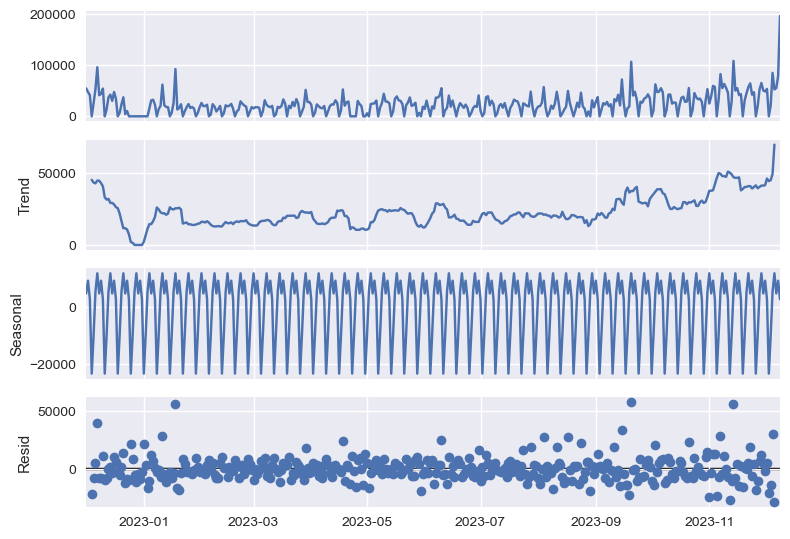

In [155]:
# Descomponemos la serie temporal para identificar tendencis, estacionalidad y ruido
result = seasonal_decompose(df_ax, model = 'additive', period = 7)
result.plot()
plt.show()

# vemos en la grafica de trend y seasonal que hay unos gaps comentados anterioremente.
# respecto a la estacionalidad, ajustando los datos a 7 dias(semanal) podemos apreciar que hay un pico qeu luego vuelve a bajar,
#  intuyo que será los fines de semana y luego el resto de la semana.

# respecto al ruido, se distribuye como esperabamos , viendo algun que otro outlier.




In [156]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt

In [157]:
# Add the results of the decomposition to the dataframe

df_ax['observed'] = result.observed
df_ax['trend'] = result.trend
df_ax['seasonal'] = result.seasonal
df_ax['residual'] = result.resid


df_ax.head()

,value,observed,trend,seasonal,residual
Date,,,,,
2022-12-01,54613.88,54613.88,NaN,4600.234488,NaN
2022-12-02,47451.57,47451.57,NaN,9012.653582,NaN
2022-12-03,41259.36,41259.36,NaN,2569.742969,NaN
2022-12-04,0.00,0.00,45379.685714,-23166.735045,-22212.95067
2022-12-05,25400.92,25400.92,43457.700000,-9816.751010,-8240.02899


In [158]:
df_ax['estimated'] = df_ax['trend'] + df_ax['seasonal']
df_matrix = df_ax[['value', 'estimated']].copy()
df_matrix = df_matrix[df_matrix['estimated'].isna() == False]
df_matrix.head(5)

,value,estimated
Date,,
2022-12-04,0.00,22212.950670
2022-12-05,25400.92,33640.948990
2022-12-06,53060.38,48182.428155
2022-12-07,95871.69,56373.096861
2022-12-08,41159.98,49398.765917


In [159]:
px.line(df_matrix)

c:\Users\Usuario\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Vemos que mas o menos sigue la linea general dejando fuera registros con valores muy altos.

vamos a calcular ahora las siguientes metricas.

### Error Medio Absoluto (_Mean Absolute Error - MAE_)

In [160]:
mean_absolute_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value']) 

7561.1611278521295

### Error Medio Cuadrado (_Mean Squared Error - MSE_)

In [161]:
mean_squared_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value']) 

117447459.75580174

### Error cuadrático medio (_Root Mean Squared Error - RMSE_)

In [162]:
sqrt(mean_squared_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value']))

10837.31792261359

### R cuadrado (_R squared - R2_)

In [163]:
r2_score(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])

0.6641511731555516

### Error porcentual absoluto medio (_Mean Absolute Percentage Error - MAPE_)

In [164]:
mean_absolute_percentage_error(y_pred = df_matrix['estimated'], y_true = df_matrix['value'])

7.314230797371642e+18

## Comentario evaluacion metricas.

Las métricas comunes utilizadas en series temporales para evaluar el rendimiento de modelos predictivos son:

**R2 (Coeficiente de Determinación)**: 0.66415
Significado: Mide la proporción de la variación en la variable dependiente que es predecible a partir de las variables independientes. Un valor de 1 indica una predicción perfecta, mientras que 0 indica que el modelo no explica la variabilidad de los datos.
Valores aceptables: Cuanto más cercano a 1, mejor. Un valor negativo puede indicar un rendimiento deficiente.


**MAE (Error Absoluto Medio)**:7561.16
Significado: Representa el promedio de las diferencias absolutas entre las predicciones y las observaciones reales. Mide la magnitud promedio de los errores.
Valores aceptables: Cuanto más bajo, mejor. Se interpreta directamente en la unidad de la variable objetivo.   La media es de mean=23055.03, entonces si hay cierto error (7561)


**MAPE (Error Porcentual Absoluto Medio)**:7.314230797371642e+18
Significado: Calcula el promedio de los errores porcentuales absolutos en relación con las observaciones reales.
Valores aceptables: Como regla general, valores más bajos son mejores. Sin embargo, puede haber casos en los que el MAPE sea alto debido a denominadores pequeños.
Esto me parece una barbaridad


**RMSE (Error Cuadrático Medio)**:10837.31
Significado: Es la raíz cuadrada del promedio de los errores al cuadrado. Similar al MAE, pero penaliza más los errores grandes.
Valores aceptables: Cuanto más bajo, mejor. Se interpreta en la misma unidad que la variable objetivo. Esto es bastante alto a mi parecer



### Tendencia y Estacionaridad

In [165]:
# Ahora vamos a hacerles los test de Mann-Kendall para evaluar si hay tendencia en nuestros datos y test ADF (Dickey-Fuller) para comprobar la estacionaridad.

In [166]:
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white

def check_trend(time_series, alpha=0.05):
    """
    Perform the Mann-Kendall test for stationarity on a time series.
    
    H0: No monotonic trend --> Stationary
    Ha : Monotonic trend is present --> Non-Stationary (i.e.  trend exists)
    
    Assumptions
    
    - No correlation
    - No seasonality



    Parameters:
    - time_series: pandas Series or DataFrame column containing the time series data.
    - alpha: Significance level for the test.

    Returns:
    - result: pymannkendall test result object.
    """
    result = mk.original_test(time_series, alpha=alpha)
    return result

In [172]:
df_ax.drop(labels=['observed','trend','seasonal','residual','estimated'],axis=1,inplace=True)
df_ax

,value
Date,
2022-12-01,54613.88
2022-12-02,47451.57
2022-12-03,41259.36
2022-12-04,0.00
2022-12-05,25400.92
...,...
2023-12-05,84911.52
2023-12-06,52473.05
2023-12-07,55214.81


In [173]:
check_trend(df_ax, alpha=0.05)

# Tenemos un p-value de p=9.121081667728959e-11 (proximo a 0), entonces podemos asumir que la serie tiene tendencia (rechazamos hipotesis nula de estacionaridad)

Mann_Kendall_Test(trend='increasing', h=True, p=9.121081667728959e-11, z=6.4808442928025025, Tau=0.22375306447219395, s=15607.0, var_s=5798558.333333333, slope=55.24790262172286, intercept=10531.961161048686)

In [174]:
# Check stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_ax, autolag='AIC') # chooses the number of lags that renders the lowest AIC

#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'n_lags', 'n_observations', 'critical' 'values', 'icbest'], result))

{'adf': -0.3880727458399856,
 'pvalue': 0.9120712357216472,
 'n_lags': 13,
 'n_observations': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7870.783124841713}

In [ ]:
# el pvalue = 0.91 por lo que podemos rechazar la hipotesis alternativa de que la serie temporal es estacionaria. 

# tendremos que hacerla estacionaria mas adelante y eliminar la tendencia para que nuestro modelo funcione correctamente

In [175]:
# DIFERENCIACION PARA APLICAR ESTACIONARIDAD
#  Aplicar la primera diferencia
df_stationary = df_ax.diff().dropna()

# Verificar estacionaridad
result_diff = adfuller(df_stationary['value'])

#Usamos la misma tecnica para visualizar los resultados del test
dict(zip(['adf', 'pvalue', 'n_lags', 'n_observations', 'critical' 'values', 'icbest'], result_diff))

# podemos concluir que hemos aplicado la diferenciacion correctamente dando lugar a una serie temporal estacionaria (p-value<0.05)

{'adf': -5.883394323205705,
 'pvalue': 3.0410448917429774e-07,
 'n_lags': 12,
 'n_observations': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7847.901049002474}

In [176]:
px.line(df_stationary)

c:\Users\Usuario\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<function matplotlib.pyplot.show(close=None, block=None)>

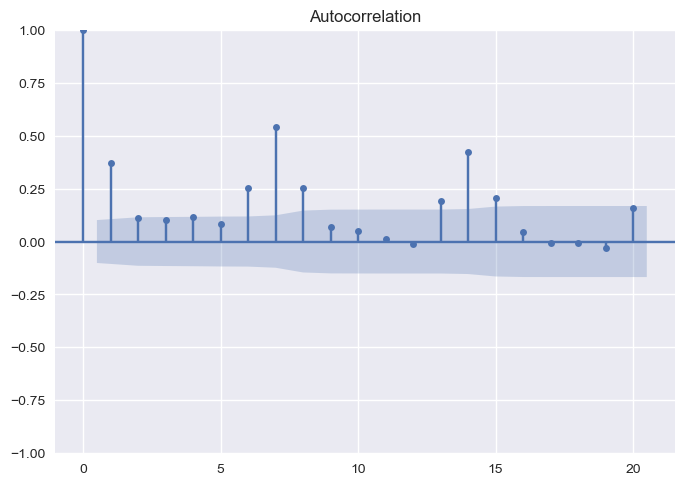

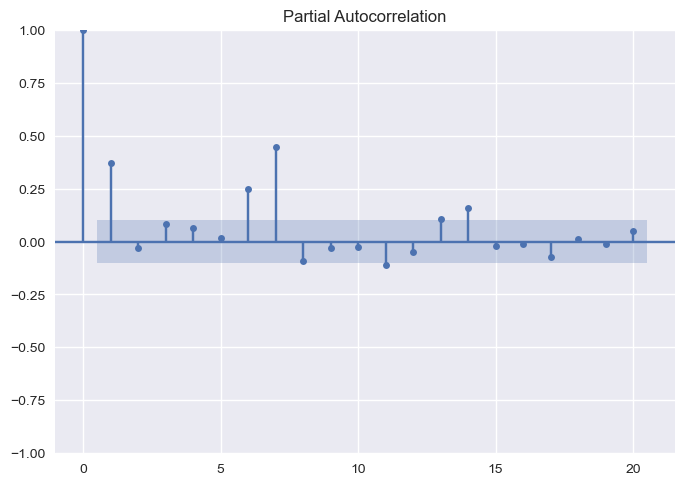

In [177]:
# OBTENEMOS LOS GRAFICOS DE AUTOCORRELACION AJUSTADO A 100 DIAS

# Plot the ACF and PACF of the generated TS
plot_acf(df_ax, lags=20)
plot_pacf(df_ax, lags=20)
plt.show


# En los graficos de autocorrelacion vemos que hay retardos importantes que cada 7 retardos saltan. Esto supongo que tiene relacion con la semana. Imagino que hay un dia
# de la semana que se vende mas que ninguno siempre, por ejemplo, la gente suele hacer las compras los miercoles

Dado que has identificado la presencia de tendencia pero la falta de estacionaridad en tus datos de series temporales, hay varios pasos que podrías considerar para construir tu modelo de predicción. Aquí hay algunas sugerencias:

**Diferenciación**: Intenta aplicar diferenciación para hacer que tus datos sean estacionarios. Puedes realizar la primera diferencia (df.diff()) y verificar nuevamente la estacionaridad con el test de Dickey-Fuller. Puedes continuar diferenciando hasta lograr la estacionaridad.

**Transformación**: Si la tendencia es evidente pero difícil de eliminar, considera aplicar alguna transformación a tus datos, como la transformación logarítmica o la raíz cuadrada. Luego, verifica la estacionaridad nuevamente.

**Modelo ARIMA**: Después de obtener una serie temporal estacionaria, podrías considerar utilizar un modelo ARIMA para predecir los valores futuros. ARIMA es eficaz para manejar datos con tendencia y estacionalidad.

**Validación del Modelo**: Divide tus datos en conjuntos de entrenamiento y prueba. Entrena el modelo en el conjunto de entrenamiento y evalúa su rendimiento en el conjunto de prueba. Ajusta los parámetros del modelo según sea necesario.

**Optimización del Modelo**: Experimenta con diferentes configuraciones de hiperparámetros, realiza validación cruzada y ajusta tu modelo para mejorar su rendimiento.

Estos son pasos generales y pueden variar según la naturaleza específica de tus datos y el problema que estás abordando. Asegúrate de ajustar los detalles según las características de tus datos y el contexto de tu problema.

In [178]:
# DIFERENCIACION PARA APLICAR ESTACIONARIDAD
#  Aplicar la primera diferencia
df_stationary = df_ax.diff().dropna()

# Verificar estacionaridad
result_diff = adfuller(df_stationary['value'])

#Usamos la misma tecnica para visualizar los resultados del test
dict(zip(['adf', 'pvalue', 'n_lags', 'n_observations', 'critical' 'values', 'icbest'], result_diff))

# podemos concluir que hemos aplicado la diferenciacion correctamente dando lugar a una serie temporal estacionaria (p-value<0.05)

{'adf': -5.883394323205705,
 'pvalue': 3.0410448917429774e-07,
 'n_lags': 12,
 'n_observations': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7847.901049002474}

In [179]:
check_trend(df_stationary,0.05)

# comprobamos si tiene tendencia: p-value>0.05 --> ausencia de tendencia. podemos concluir que hemos generado una serie temporal estacionaria y sin tendencia.
# Los datos estan preparados para nuestro modelo.

Mann_Kendall_Test(trend='no trend', h=False, p=0.6121099407862443, z=0.5070639610915584, Tau=0.017599238951829112, s=1221.0, var_s=5788875.0, slope=4.461378153784548, intercept=400.67366339607213)

In [180]:
px.line(df_stationary)

c:\Users\Usuario\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



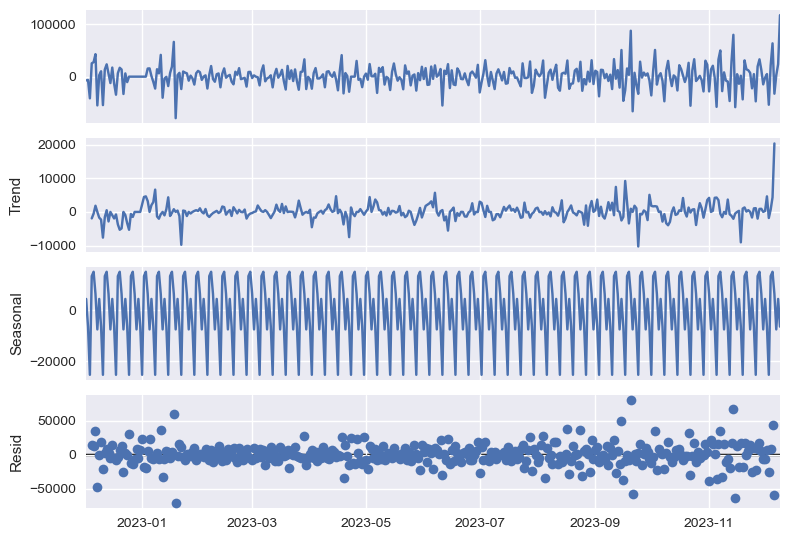

In [39]:
result = seasonal_decompose(df_stationary, model = 'additive', period = 7)
result.plot()
plt.show()


## 4 ARIMA

El modelo se denomina modelo Autorregresivo Integrado de Medias Moviles de orden (p,d,q) o ARIMA(p,d,q),donde p es el orden del polinomio autorregresivo estacionario, d es el orden de integracion de la serie,es decir,el numero de diferencias que hay que tomar a la serie para que sea estacionaria,y q es el orden del polinomio de medias moviles invertible.

Para datos no estacionarios, los valores en el model ARIMA (p, d, q) representan:
+ p: Número de observaciones de retraso incluidas en el modelo, también llamado orden de retraso
+ d: Número de veces que se diferencian las observaciones sin procesar, también llamado grado de diferenciación.
+ q: Tamaño de la ventana del promedio móvil, también llamado orden del promedio móvil.

En caso de tener datos estacionales, también debemos aplicar las diferencias estacionales. En este caso el modelo ARIMA se expresa como SARIMA e incluye un componente estacional (P, D, Q)

In [197]:
# para la division entre train y test vamos a tomar 3 meses para el test.

df_train = df_stationary.head(df_stationary.shape[0] - 90)[['value']]
df_test = df_stationary.tail(90)[['value']]
print(df_stationary.shape)
print(df_train.shape)
print(df_test.shape)

(373, 1)
(283, 1)
(90, 1)


In [198]:
auto_arima_pax = auto_arima(df_train['value'],
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=7,  # Estacionalidad semanal
                       seasonal=True,
                       D=1, #Hemos hecho una diferenciacion
                       max_d=3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
auto_arima_pax.summary()

# aqui el ARIMA lo hace automatico buscando los mejores hiperparametros. los parametros P Q suelen variar entre 0-5, la D son las diferenciacion. En nuestro caso lo hemos ajustado D=1 
# porque ya habiamos hecho una diferenciacion previa.

Performing stepwise search to minimize aic


 ARIMA(2,0,1)(1,1,1)[7] intercept   : AIC=5946.084, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6138.969, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6057.792, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5911.396, Time=1.16 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6137.058, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=6036.960, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=5944.740, Time=0.79 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=5905.734, Time=2.59 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=5944.301, Time=2.21 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=5934.699, Time=3.02 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=5994.521, Time=0.90 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=5934.733, Time=5.02 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=5942.479, Time=0.83 sec

Best model:  ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  283
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -2947.867
Date:                                Sun, 04 Feb 2024   AIC                           5905.734
Time:                                        14:12:40   BIC                           5923.836
Sample:                                    12-02-2022   HQIC                          5912.998
                                         - 09-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.6786     24.443      0.519      0.604     -35.228      60.585
ma.L1         -0.7491      0.035    -21.379      0.000      -0.818      -0.680
ma.S.L7       -0.7339      0.047    -15.505      0.000      -0.827      -0.641
ma.S.L14      -0.1693      0.044     -3.867      0.000      -0.255      -0.083
sigma2      1.079e+08   1.69e-05   6.38e+12      0.000    1.08e+08    1.08e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                68.54
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.58
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+28. Standard errors may be unstable.
"""

In [202]:
# Segun el analisis AutoARIMA, los parametros que mejor funcionan son los siguietnes:

'''
Best model:  ARIMA(3,0,2)(1,0,1)[12] intercept
Total fit time: 45.784 seconds


Best model:  ARIMA(2,0,1)(0,1,1)[12] intercept

Best model:  ARIMA(0,0,1)(0,1,2)[7] intercept
Total fit time: 24.655 seconds


DATOS SIN DIFERENCIACION
Best model:  ARIMA(2,0,3)(1,0,2)[7]          
Total fit time: 70.163 seconds

'''
# ajustamos el modelo arima a los parametros correctos

model_auto = SARIMAX(df_train['value'],order=(0, 0, 1),
              seasonal_order=(0, 1, 2, 7),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()
print(results_auto_arima.summary())




                                       SARIMAX Results                                        
Dep. Variable:                                  value   No. Observations:                  283
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -2790.639
Date:                                Sun, 04 Feb 2024   AIC                           5589.278
Time:                                        14:14:25   BIC                           5603.521
Sample:                                    12-02-2022   HQIC                          5595.004
                                         - 09-10-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7497      0.060    -12.599      0.000      -0.866      -0.633
ma.

In [203]:

forecast_auto_arima = results_auto_arima.predict(start = len(df_train),
                           end=len(df_train)+90,
                           typ='levels').rename('forecast_auto_arima')



c:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



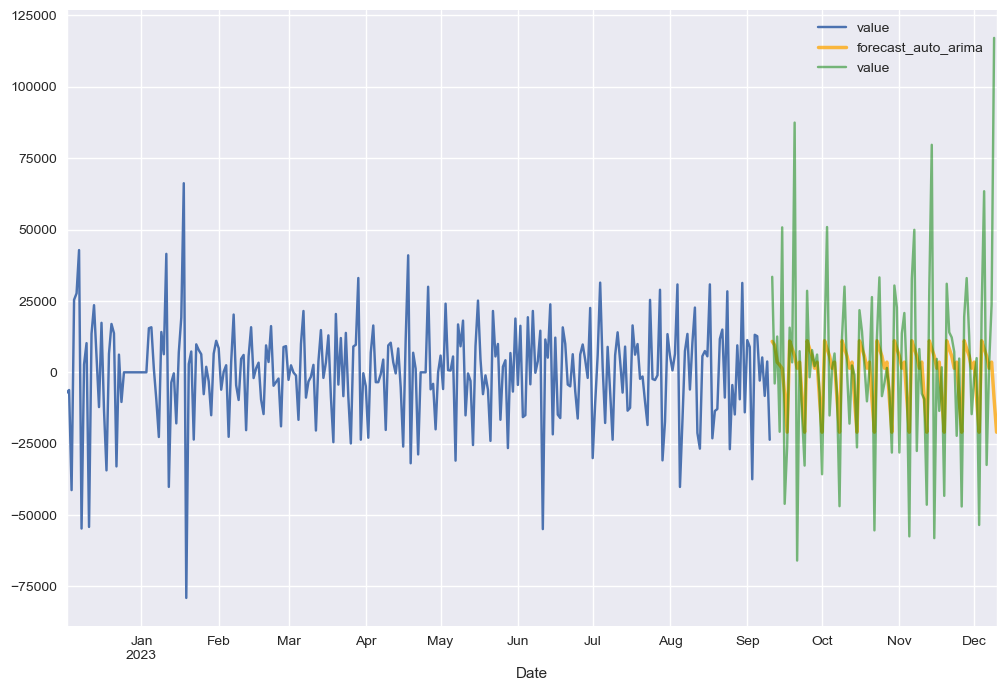

In [204]:
# Plot forecasts 
df_train['value'].plot(figsize=(12,8),legend=True)
forecast_auto_arima.plot(legend=True, color='orange', alpha=0.75, linewidth=2.5)
df_test['value'].plot(legend=True,color='green', alpha=0.5)

plt.show()

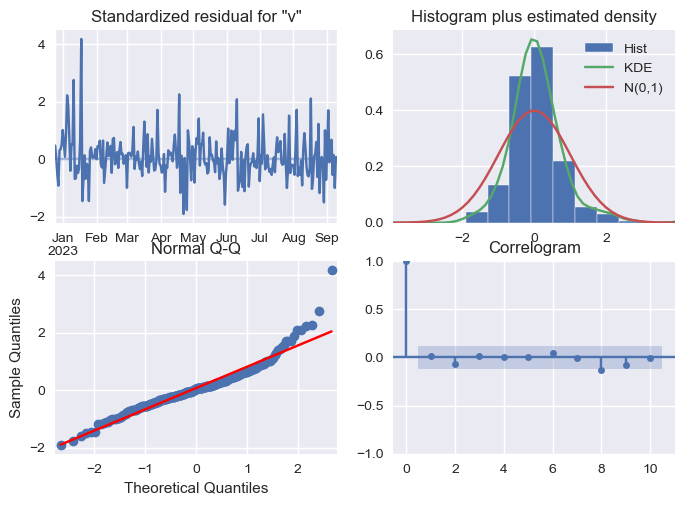

In [205]:
diag = results_auto_arima.plot_diagnostics()

In [206]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# Asegurémonos de que ambas series temporales tengan la misma longitud
min_length = min(len(forecast_auto_arima), len(df_test['value']))
forecast_auto_arima = forecast_auto_arima[:min_length]
df_test['value'] = df_test['value'][:min_length]

# Calculamos el RMSE
rmse = sqrt(mean_squared_error(y_pred=forecast_auto_arima, y_true=df_test['value']))
print(f'RMSE: {round(rmse, 3)}')


RMSE: 27552.743


XGBOOST


In [220]:
# Supongamos que df_ax es tu DataFrame con la columna 'value' y 'date'
# Asegúrate de tener tu DataFrame ordenado por fecha antes de realizar la división
df_ax = df_ax.sort_values(by='Date')

# Calcula el índice para dividir tus datos
split_index = int(0.75 * len(df_ax))  # El 75% para entrenamiento, 25% para prueba (desde septiembre digamos)

# Divide los datos
y_train = df_ax.iloc[:split_index]
y_test = df_ax.iloc[split_index:]

# Muestra la forma y las primeras y últimas filas de los conjuntos de entrenamiento y prueba
display(train_data.shape, train_data.head(2), train_data.tail(2))
display(test_data.shape, test_data.head(2), test_data.tail(2))


(280, 1)

,value
Date,
2022-12-01,54613.88
2022-12-02,47451.57


,value
Date,
2023-09-05,25786.19
2023-09-06,22884.43


(94, 1)

,value
Date,
2023-09-07,28093.48
2023-09-08,19828.28


,value
Date,
2023-12-08,78998.25
2023-12-09,196114.48


## Definición del horizonte de pronóstico

- Consideramos la muestra de evaluación  

- Empezamos con pronósticos dentro de la muestra

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose


from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error

import xgboost as xgb

from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, SingleWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV 
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

ImportError: cannot import name 'SingleWindowSplitter' from 'sktime.forecasting.model_selection' (c:\Users\Usuario\anaconda3\Lib\site-packages\sktime\forecasting\model_selection\__init__.py)

In [221]:
# Forecasting horizon

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh


ForecastingHorizon(['2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10',
               '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14',
               '2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18',
               '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22',
               '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30',
               '2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24',
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
 

### Naive

In [223]:
forecaster = NaiveForecaster(strategy="last") # last, mean, drift --> estrategias de naive forecaster. Last es similar a recursive en 'xgboost'
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

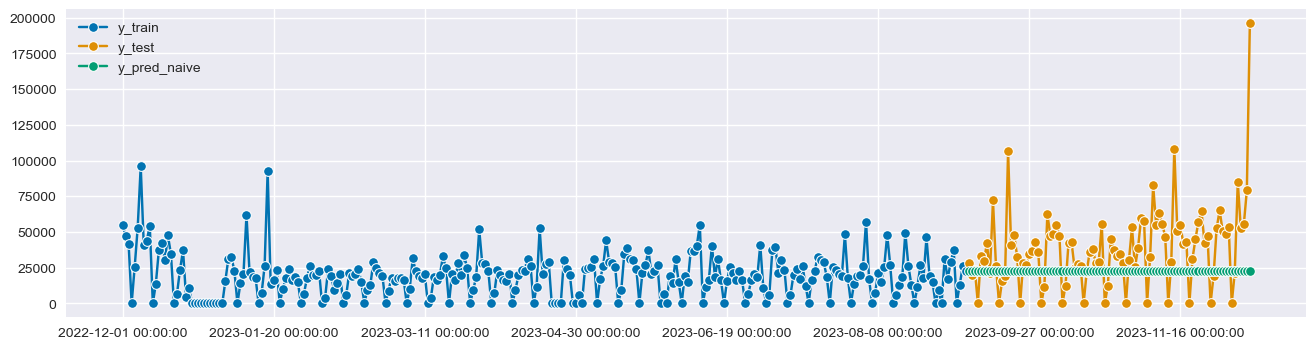

In [224]:
plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred_naive"])

- Sale una línea porque el modelo está considerando únicamente el último valor de la serie temporal para hacer la predicción.

- No es muy informativo, hay que modificar la muestra de datos que queremos que considere el modelo para predecir. 

- Vamos introducir una periodicidad estacional (sp) de 5 (según lo que hemos visto en el gráfico PACF) 

In [225]:
forecaster = NaiveForecaster(strategy="last", sp=5)
forecaster.fit(y_train)
y_pred_naive_imp = forecaster.predict(fh)


c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

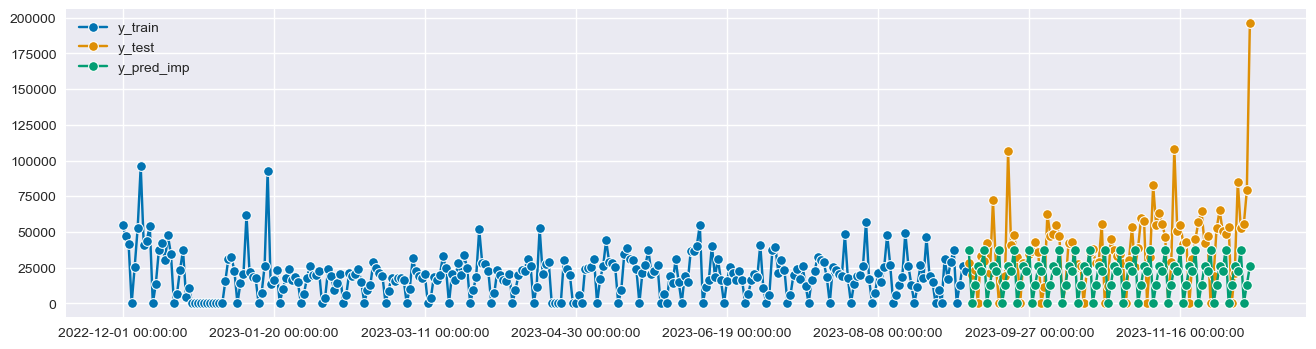

In [226]:
plot_series(y_train, y_test, y_pred_naive_imp, labels=["y_train", "y_test", "y_pred_imp"])

### XGBoost

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

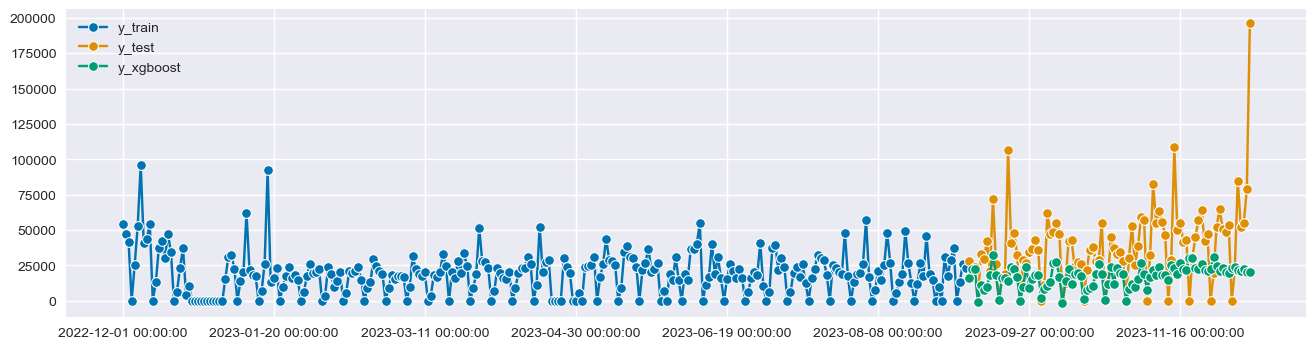

In [227]:
from xgboost import XGBRegressor 


xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive, direct, mulitoutput
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

### KNN 

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be re

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

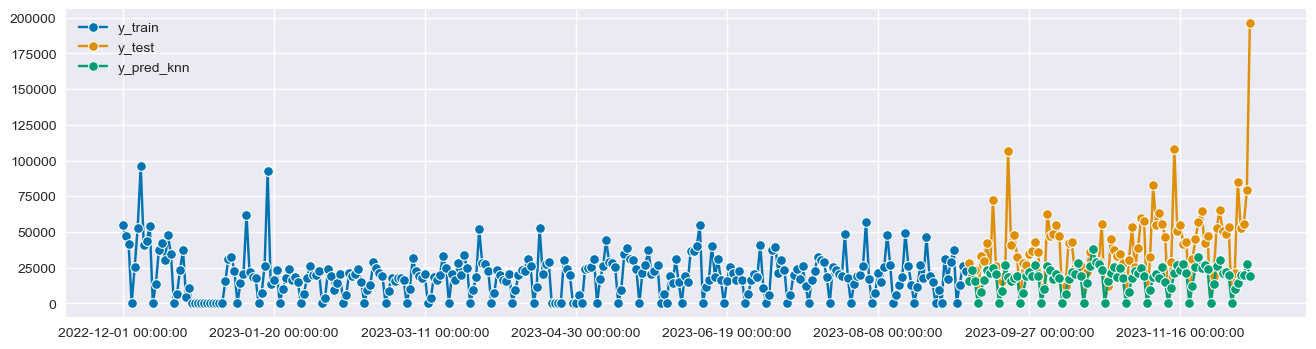

In [228]:
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, strategy="recursive", window_length=7)
forecaster.fit(y_train.dropna(), fh=fh)
y_pred_knn = forecaster.predict()
plot_series(y_train, y_test, y_pred_knn, labels=["y_train", "y_test", "y_pred_knn"])

## Evaluación de los modelos

In [229]:
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mae_naive_imp = mean_absolute_error(y_test, y_pred_naive_imp)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

# create data frame with mape values

maes = [mae_naive, mae_naive_imp,  mae_xgboost, mae_knn]
models = ['Naive', 'Naive Improved', 'XGBoost', 'KNN']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)


,Model,MAE
3,KNN,21270.188721
0,Naive,22928.813532
2,XGBoost,23497.765677
1,Naive Improved,26189.259277


#### Transformadores

In [234]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender


import warnings 
warnings.filterwarnings('ignore')

In [243]:
y_train['value']= y_train['value']+1

In [244]:
# Source: Full set of transformers is in here: https://sktime-backup.readthedocs.io/en/v0.13.0/api_reference/transformations.html#


xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# fit a forecaster with transformers aimed at deseasonalizing and detrending the data
forecaster = forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_year", Deseasonalizer(model="multiplicative", sp=12)),
        ('LogTransformer', LogTransformer()),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=12, scitype='tabular-regressor')),
        
    ]
    
)

forecaster.fit(y_train)
y_pred_transf = forecaster.predict(fh)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

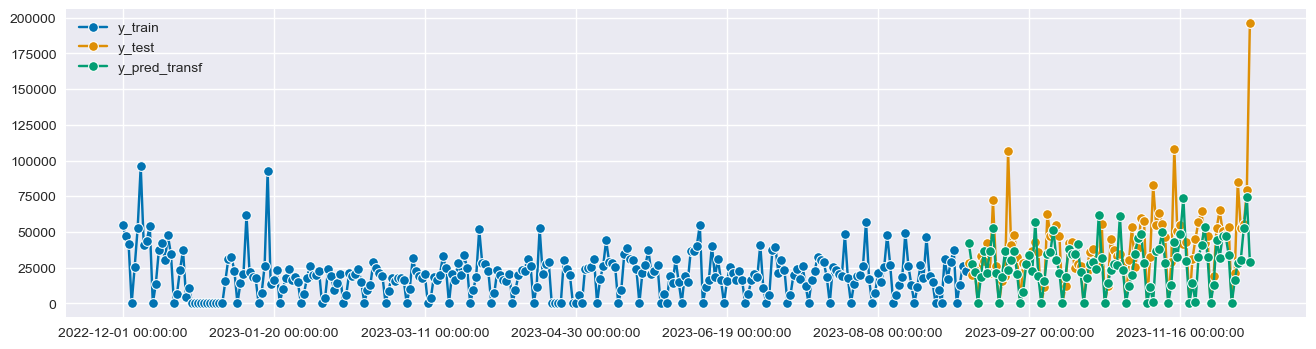

In [245]:
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

In [246]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf, symmetric=False)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=True)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

,eval_xgb
MAPE,9.316386e+14
MAE,1.601108e+04
RMSE,7.483278e+08


####  Tunear hiperparametros, utilizar validación cruzada y re-entrenar

Hay que definir varias cosas

- El conjunto de hiperparámetros a tunear

- La forma en que vamos a dividir la serie temporal para llevar a cabo la validación cruzada. 







In [247]:
# Definimos el tamaño de la muestra para hacer la validación

validation_size = len(y_test)
validation_size


94

In [248]:
# Definimos muestra para la validación cruzada 

cv = ExpandingWindowSplitter(initial_window=36,
                                step_length=12,
                             fh=validation_size)

In [249]:
# mantener estos parametros, es con lo que mejor funciona segun el.

param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}


rscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=cv, 
                                     param_distributions=param_grid,
                                     n_iter=100, 
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)


In [251]:
result_cv = rscv.fit(y_train)

y_pred_transf_cv = rscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

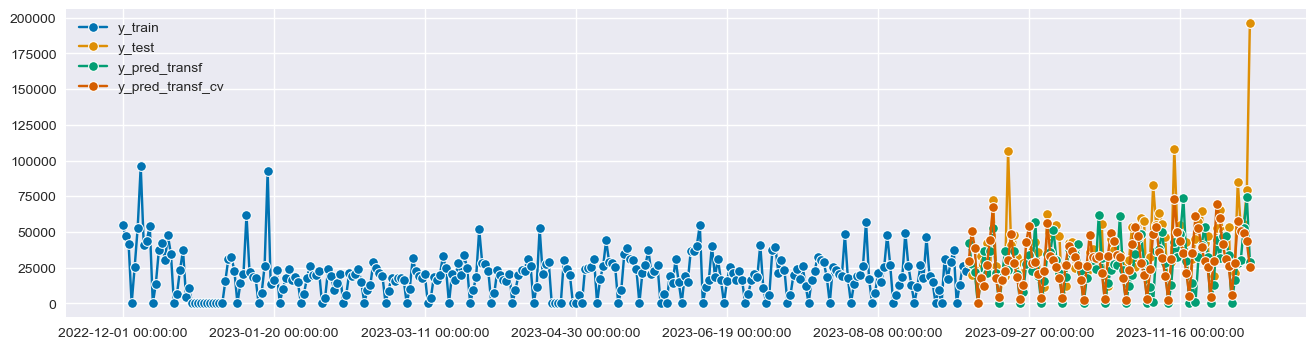

In [252]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

Vemos que tras la cv ha mejorado la grafica bastante

In [253]:
# Evaluacion 


mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv, symmetric=False)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=True)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

,eval_xgb_transf_cv
MAPE,2.071648e+18
MAE,1.479928e+04
RMSE,6.236473e+08


### Pronóstico fuera de la muestra

In [255]:
y_test

,value
2023-09-07,28093.48
2023-09-08,19828.28
2023-09-09,23620.43
2023-09-10,0.00
2023-09-11,33440.65
...,...
2023-12-05,84911.52
2023-12-06,52473.05
2023-12-07,55214.81
2023-12-08,78998.25


In [265]:
fhos = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-09-07", periods=180, freq="D")), is_relative=False
)
fhos


# definimos el horizonte de pronostico a 3 meses

ForecastingHorizon(['2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10',
             '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14',
             '2023-09-15', '2023-09-16',
             ...
             '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
             '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-02',
             '2024-03-03', '2024-03-04'],
            dtype='period[D]', length=180, is_relative=False)

In [268]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

AssertionError: 

No consigo resolver un fallo que me da. pero desde aqui evaluaria cómo de creible es nuestro modelo de cara a los 3 meses a predecir.

In [270]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])


NameError: name 'y_pred_transf_oos' is not defined

## Comentarios

Me ha resultado bastante dificil entender esta parte de Time Series. No obstante he conseguido llegar más alla de lo que inicialmente pensaba que llegaría.

Los conceptos generales los entiendo bien, pero me veo asaltado por multitud de errores (que no deberian pasar) por incompatibilidades de bibliotecas entiendo, que en definitiva me ha hecho mucho mas dificil, lento y espeso el avance del proyecto. A decir verdad algo frustrado o desesperado cuando ocurrian.

Estoy seguro que con tiempo y calma podré tanto profundizar como reforzar todos los conceptos, pero por el momento es lo que hay.

Saludos y gracias por la info.


# Añadimos transformadores

- Idea: Incorporar el pre procesamiento de los datos como parte del `forecaster`




In [232]:
from sktime.forecasting.model_selection import SingleWindowSplitter


ImportError: cannot import name 'SingleWindowSplitter' from 'sktime.forecasting.model_selection' (c:\Users\Usuario\anaconda3\Lib\site-packages\sktime\forecasting\model_selection\__init__.py)

In [230]:
# Pipeline ---------------

# Define the forecasting horizon
from sktime.transformations.series.boxcox import BoxCoxTransformer


fh = ForecastingHorizon(y_test.index, is_relative=False)
validation_size = len(y_test) # necesaria para hacer la validiación cruzada
cv = SingleWindowSplitter(window_length=len(accidentes_2023)-validation_size,  # training window length
                          fh=validation_size) # forecasting horizon



# Ajusta el regresor y los transformadores que necesitemos
# Source: https://www.sktime.net/en/stable/api_reference/transformations.html
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_week", Deseasonalizer(model="additive", sp=5)),         # desestacionaliza cada 5 días
        ("deseasonalize_month", Deseasonalizer(model="additive", sp=30)),        # desestacionaliza cada 30 días
        ('LogTransformer', BoxCoxTransformer(method= 'guerrero', sp=5)),         # corrige heterocedasticidad. aplicamos sp si utlizamos guerrero si no, no hace falta y utiliza mle como método por defecto para estimar lambda
        ('HampelFilter', HampelFilter(window_length=30)),                       # suaviza outliers
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))), # elimina tendencia
        ("forecast", make_reduction(regressor, window_length=30, scitype='tabular-regressor')), # ajusta el modelo considerando los últimos 30 días 
        
    ]
)


model= make_reduction(regressor, window_length=30,  scitype='tabular-regressor')



param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20,30],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100,200,300, 500, 1000]
}
gscv = ForecastingRandomizedSearchCV(model, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42,error_score='raise',n_jobs=-1)

gscv.fit(y_train)
y_pred_cv_xgb = gscv.predict(fh)

NameError: name 'SingleWindowSplitter' is not defined

Me encuentro con distintos errores que me hacen imposible progresar en la evolucion del proyecto:


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[230], line 9
      7 fh = ForecastingHorizon(y_test.index, is_relative=False)
      8 validation_size = len(y_test) # necesaria para hacer la validiación cruzada
----> 9 cv = SingleWindowSplitter(window_length=len(accidentes_2023)-validation_size,  # training window length
     10                           fh=validation_size) # forecasting horizon
     14 # Ajusta el regresor y los transformadores que necesitemos
     15 # Source: https://www.sktime.net/en/stable/api_reference/transformations.html
     16 regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

NameError: name 'SingleWindowSplitter' is not defined

In [ ]:
df_k_mensual['date'] = df_k_mensual.index
df_k_mensual['dayofweek'] = df_k_mensual['date'].dt.dayofweek
df_k_mensual['quarter'] = df_k_mensual['date'].dt.quarter
df_k_mensual['month'] = df_k_mensual['date'].dt.month
df_k_mensual['year'] = df_k_mensual['date'].dt.year
df_k_mensual['dayofyear'] = df_k_mensual['date'].dt.dayofyear
df_k_mensual['dayofmonth'] = df_k_mensual['date'].dt.day
df_k_mensual['weekofyear'] = df_k_mensual['date'].dt.isocalendar().week.astype(int)

X = df_k_mensual[['dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear']]

y = df_k_mensual[['Temp_2m']]


In [ ]:
X_train = X.head(X.shape[0] - 12)
X_test = X.tail(12)
y_train = y.head(X.shape[0] - 12)
y_test = y.tail(12)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(456, 7)
(12, 7)
(456, 1)
(12, 1)


In [ ]:
y_test

,Temp_2m
Date,
2019-01-31,8.624839
2019-02-28,10.590357
2019-03-31,14.169355
2019-04-30,19.123333
2019-05-31,22.096774
2019-06-30,23.275667
2019-07-31,21.499032
2019-08-31,21.316774
2019-09-30,19.507333


In [ ]:
X_train.dtypes

dayofweek     int64
quarter       int64
month         int64
year          int64
dayofyear     int64
dayofmonth    int64
weekofyear    int32
dtype: object

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=200,objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train, y_train,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

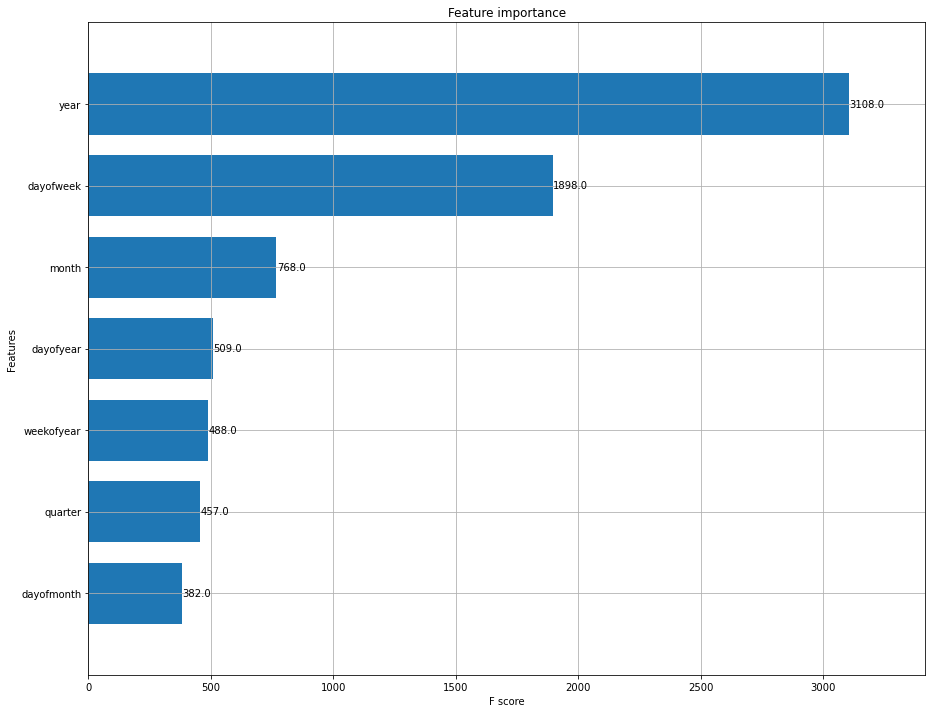

In [ ]:
_ = plot_importance(model_xgb, height = 0.75)

In [ ]:
y_pred = model_xgb.predict(X_test)
y_pred

array([ 8.588515, 12.005308, 15.735266, 18.600266, 20.673311, 22.018248,
       21.301277, 21.009037, 19.259823, 16.298391, 13.732845,  9.7744  ],
      dtype=float32)

In [ ]:
rmse = sqrt(mean_squared_error(y_pred = y_pred, y_true = y_test['Temp_2m']))
print(f'RMSE: {round(rmse,3)}')

RMSE: 0.965


In [ ]:
df = df_k_mensual.copy()
df

,Temp_2m,Diferencia,observed,trend,seasonal,resid,estimated,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,
1981-01-31,7.498387,NaN,7.498387,NaN,-8.136620,NaN,NaN,1981-01-31,5,1,1,1981,31,31,5
1981-02-28,11.256429,NaN,11.256429,NaN,-5.909298,NaN,NaN,1981-02-28,5,1,2,1981,59,28,9
1981-03-31,14.476129,NaN,14.476129,NaN,-1.533356,NaN,NaN,1981-03-31,1,1,3,1981,90,31,14
1981-04-30,18.382333,NaN,18.382333,NaN,2.828913,NaN,NaN,1981-04-30,3,2,4,1981,120,30,18
1981-05-31,20.994516,NaN,20.994516,NaN,5.205792,NaN,NaN,1981-05-31,6,2,5,1981,151,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,21.316774,0.410000,21.316774,NaN,4.140305,NaN,NaN,2019-08-31,5,3,8,2019,243,31,35
2019-09-30,19.507333,-0.384000,19.507333,NaN,2.813324,NaN,NaN,2019-09-30,0,3,9,2019,273,30,40
2019-10-31,16.337419,0.467097,16.337419,NaN,-0.021482,NaN,NaN,2019-10-31,3,4,10,2019,304,31,44


In [ ]:
df.index.max()

Timestamp('2019-12-31 00:00:00', freq='M')

Entrenamiento de XGBOOST con Split Cross Validation

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(X_train.index.min(), X_train.index.max())

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print(f"Promedio RMSE: {sum(rmse_scores) / len(rmse_scores)}")


1981-01-31 00:00:00 1987-06-30 00:00:00
1981-01-31 00:00:00 1993-12-31 00:00:00


1981-01-31 00:00:00 2000-06-30 00:00:00
1981-01-31 00:00:00 2006-12-31 00:00:00
1981-01-31 00:00:00 2013-06-30 00:00:00
Promedio RMSE: 1.0829442140382972


In [ ]:
# Fit the best model to the data

model_auto = SARIMAX(df_train['value'],order=(3, 0, 2),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()

In [ ]:
# TRANSFORMACION PARA ELIMINAR TENDENCIA
# Aplicar transformación logarítmica
df_log = np.log(df_stationary['value'])

# Verificar estacionaridad
result_log = adfuller(df_log)
result_log


c:\Users\Usuario\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



MissingDataError: exog contains inf or nans

ValueError: could not broadcast input array from shape (305,) into shape (366,)

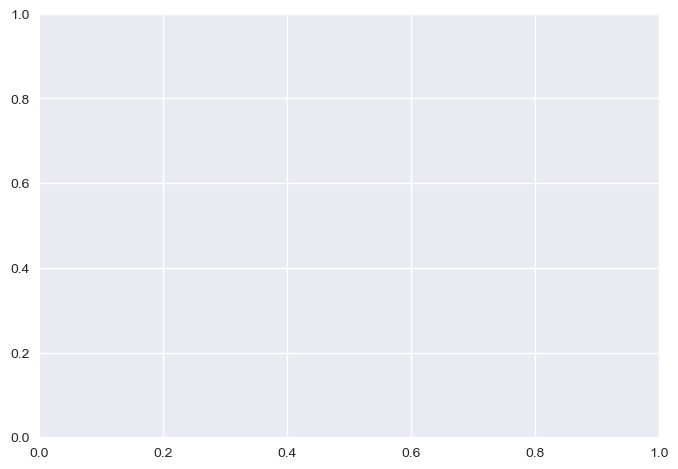

In [ ]:
# Plot the ACF and PACF of the generated TS
plot_acf(df_ax, lags=365)
plot_pacf(df_ax, lags=365)
plt.show

![Aqui he incluido una captura de pantalla de la diapositiva con el esquema de las etapas de la checklist de ML, está en local asi que no lo podrás ver. Lo he hecho para organización personal](cosas_que_hacer.PNG)